Why this project? 

I've been tinkering about getting a new laptop as mine is nearly 10 years old, and I'll probably have to invest some time into looking up my options, I might as well just do it here, killing two birds with one stone. Time is a precious thing. 

Gameplan:

*   Get the data by scraping notebook.hu (~1-2 hours tops)
*   Clean the data (~2 hours)
*   Basic EDA, data viz (~1-2 hours)
*   Feature engineering (all the (remaining) time)
*   Benchmarking (~30min)
*   Hyperparam opt(~1 hour)
*   Deployment (~1-2 hours)

If I manage not to cross these time-boundaries, I'll finish the project under 10 hours. 

I should build a pipeline as fast as I can, and then assign the remaining time between eda, feature eng and hyperparam opt. Maybe I will delay the deployment part as I haven't done it previously (and also because I will probably have to use it in a school project thats deadline is close)


In [1]:
# Tasks: 
# 1. scrape data from a webshop/ecommerce site
# 2. do some basic analysis
# 3. build a model
# 4. deploy the model
# 5. profit 

# https://www.notebook.hu/notebook?page=1&limit=72 , total 6 pages atm, most popular in front

# scraped site: notebook.hu
# Checked /robots.txt, as far as I've seen it doesn't disallow scraping /notebook, so I'm good to go
# Note to myself: make sure I don't harm/overload the sites services. 


import requests
from bs4 import BeautifulSoup
import time 


productlinks = []
for i in range(1,6):
  limit=72 #other option is 36
  baseurl = f"https://www.notebook.hu"
  pageurl = f"https://www.notebook.hu/notebook?page={i}&limit=72" 
  html = requests.get(pageurl).text
  time.sleep(3) # being nice to the server

  soup=BeautifulSoup(html,'html.parser')
  productlist = soup.find_all("div",{"class":"item-new"})
  
  
  for product in productlist:
    product_link  = baseurl + '/' + product.find("div",{"class":"thumb-wrapper"}).find('a').get('href')
    productlinks.append(product_link)
    

In [2]:
items_data = [] 

for link in productlinks:
  values_dict = {}
  html = requests.get(link).text
  time.sleep(3)
  soup = BeautifulSoup(html,'html.parser')
  values_dict['link'] = link
  for div in soup.find_all("div", {"class": "leiras"}):
    try:
      values_dict['Notebook neve'] = soup.find("div", {"class": "product-name"}).text
    except:
      values_dict['Notebook neve'] = 'Name not found'
    for li in div.find_all('li'): 
      label = li.find("span", {"class": "label"}).text
      try:
        value = li.find("span", {"class": "value"}).text
        values_dict[label] = value
      except:
        values_dict[label] = None
    try:
      values_dict['Raktáron'] = soup.find("div", {"class":"product-sales-container"}).find("div", {"class":"stock-info"}).text
    except:
      values_dict['Raktáron'] = None

    try:
      values_dict['Ár'] = soup.find("span", {"class":"regular-price"}).text
    except:
      values_dict['Ár'] = None

    try:
      values_dict['Régi Ár'] = soup.find("span", {"class":"old-price"}).text
    except:
      values_dict['Régi Ár'] = None

    try:
      values_dict['Akciós Ár'] = soup.find("span", {"class":"special-price"}).text
    except:
      values_dict['Akciós Ár'] = None


  items_data.append(values_dict)



In [4]:
import pandas as pd

df = pd.DataFrame(items_data)
df

# TODO:
# from notebook name: get brand

,link,Notebook neve,Raktáron,Ár,Régi Ár,Akciós Ár,Processzor leírás,Operációs rendszer,Memória,Háttértár,Grafikus vezérlő,Kijelző,Képfrissítés,Fényerő,LAN típus,Wi-Fi,Bluetooth,HDMI normál,USB 3.1,USB3.1 Type-C,Thunderbolt támogatás,Lighting csatlakozó,Optikai meghajtó,Billentyűzet,Audio leírás,Akkumulátor leírás,Méret,Súly,Garancia,Webkamera,USB 2.0,USB 3.0,Kártya olvasó,Extrák,További extrák,USB3.0 Type-C,Displayport mini,Érintő kijelző,HSDPA,VGA
0,https://www.notebook.hu/asus-rog-strix-g15-g51...,\nAsus ROG Strix G15 G512LI (G512LI-HN094) fek...,Raktáron,349 900 Ft,None,None,"Intel® Core™ i5-10300H Processor (8M Cache, up...",Operációs rendszer nélkül,8GB DDR4 2933MHz RAM,512GB M.2 PCIe SSD,NVIDIA® GeForce™ GTX 1650Ti 4GB GDDR6,"15.6"" FullHD (1920 x 1080) matt WVA LCD (144Hz)",144 Hz,250 nit,1000Mbps,802.11 ax,v 5.1,1 db,3 db,1 db,Nem,Nem,USB (vásárolható),"Világítás, Nincs numpad, Magyar kiosztású","2 x 1.5W hangszóró W/O Smart AMP technológia, ...",3 cellás 48Whr beépített,360.00x275.00x25.80 mm,2.30 kg,36 hónap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://www.notebook.hu/msi-gf65-thin-10ue-9s7...,\nMSI GF65 Thin 10UE (9S7-16W212-025) Fekete\n,Raktáron,None,Régi ár: 469 900 Ft,449 900 Ft,"Intel® Core™ i5-10200H Processor (8M Cache, up...",FreeDos,16GB (2x8) DDR4 3200MHz RAM,512 GB NVMe PCIe Gen3x4 SSD,NVIDIA® GeForce™ RTX 3060 6GB GDDR6,"15.6"" FullHD (1920 x 1080) matt IPS LCD",144 Hz,NaN,1000Mbps,802.11 ax,v 5.1,1 db,2 db,2 db,Nem,Nem,USB (vásárolható),"Világítás, Nincs numpad, Magyar kiosztású",1 db Mikrofon bemenet/Fejhallgató kimenet Comb...,3 cellás 51Whr beépített,359.00x254.00x21.70 mm,1.86 kg,36 hónap,HD type (30fps@720p),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://www.notebook.hu/msi-gf63-thin-10scsr-1...,\nMSI GF63 Thin 10SCSR (9S7-16R412-1017HU) Fek...,Raktáron,None,Régi ár: 349 900 Ft,309 900 Ft,"Intel® Core™ i5-10300H Processor (8M Cache, up...",FreeDos,8GB DDR4 2666MHz RAM,512 GB NVMe PCIe SSD,NVIDIA® GeForce™ GTX 1650Ti (Max-Q) 4GB GDDR6,"15.6"" FullHD (1920 x 1080) matt IPS-level LCD ...",144 Hz,NaN,1000Mbps,802.11 ax,v 5,1 db,3 db,1 db,Nem,Nem,USB (vásárolható),"Világítás, Nincs numpad, Magyar kiosztású","2x 2W Hangszóró, 1 db Mikrofon bemenet, 1 db F...",3 cellás 51Whr beépített,359.00x254.00x21.70 mm,1.86 kg,36 hónap,Beépített HD Webkamera (30fps@720p),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://www.notebook.hu/dell-g5-5500-g5500fi5u...,\nDell G5 5500 (G5500FI5UA1) Fekete\n,Raktáron,None,Régi ár: 369 900 Ft,309 900 Ft,"Intel® Core™ i5-10300H Processor (8M Cache, up...",Ubuntu (Linux),8GB (2x4) DDR4 2933MHz RAM,512GB M.2 PCIe SSD,NVIDIA® GeForce™ GTX 1650Ti 4GB GDDR6,"15.6"" FullHD (1920 x 1080) matt WVA LCD",60 Hz,250 nit,1000Mbps,802.11 ax,v 5.1,1 db,NaN,1 db,Nem,Nem,USB (vásárolható),"Világítás, Magyar kiosztású",Realtek ALC3254 Nahimic 3D Audio technológia (...,4 cellás 68Whr beépített,364.46x254.00x28.18 mm,2.55 kg,36 hónap,HD Webkamera (beépített),2 db,1 db,SD,Ujjlenyomat olvasó,NaN,NaN,NaN,NaN,NaN,NaN
4,https://www.notebook.hu/asus-vivobook-15-m509d...,\nAsus VivoBook 15 M509DA (M509DA-BR988) Szürke\n,Raktáron,179 900 Ft,None,None,AMD® Ryzen™ 3-3250U Quad-core 2.6 GHz Mobile A...,Operációs rendszer nélkül,4GB DDR4 2666MHz RAM,256 GB M.2 NVMe™ PCIe® 3.0 SSD,AMD Radeon™ Graphics,"15.6"" HD (1366 x 768) matt LCD",NaN,200 nit,NaN,802.11 ac,v 4.1,1 db,1 db,1 db,Nem,Nem,USB (vásárolható),Magyar kiosztású,"Audio by ICEpower®, SonicMaster (Close), Beépí...",2 cellás 32Whr beépített,360.00x235.00x22.90 mm,1.90 kg,24 hónap,Beépített VGA Webkamera,NaN,2 db,microSD,TPM chip,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,https://www.notebook.hu/dell-latitude-14-5420-...,\nDELL Latitude 14 5420 (NO31L542014EMEA) szür...,Raktáron,558 900 Ft,None,None,"Intel® Core™ i7-1185G7 Processor(12M Cache, up...",Microsoft Windows 10 Professional,8GB DDR4 266

In [5]:
df.to_csv('dmlab_new.csv')

In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 

#! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip # restart runtime after this

df1 = pd.read_csv('dmlab_new.csv', index_col=0)
df1.head(2)

,link,Notebook neve,Raktáron,Ár,Régi Ár,Akciós Ár,Processzor leírás,Operációs rendszer,Memória,Háttértár,Grafikus vezérlő,Kijelző,Képfrissítés,Fényerő,LAN típus,Wi-Fi,Bluetooth,HDMI normál,USB 3.1,USB3.1 Type-C,Thunderbolt támogatás,Lighting csatlakozó,Optikai meghajtó,Billentyűzet,Audio leírás,Akkumulátor leírás,Méret,Súly,Garancia,Webkamera,USB 2.0,USB 3.0,Kártya olvasó,Extrák,További extrák,USB3.0 Type-C,Displayport mini,Érintő kijelző,HSDPA,VGA
0,https://www.notebook.hu/asus-rog-strix-g15-g51...,\nAsus ROG Strix G15 G512LI (G512LI-HN094) fek...,Raktáron,349 900 Ft,NaN,NaN,"Intel® Core™ i5-10300H Processor (8M Cache, up...",Operációs rendszer nélkül,8GB DDR4 2933MHz RAM,512GB M.2 PCIe SSD,NVIDIA® GeForce™ GTX 1650Ti 4GB GDDR6,"15.6"" FullHD (1920 x 1080) matt WVA LCD (144Hz)",144 Hz,250 nit,1000Mbps,802.11 ax,v 5.1,1 db,3 db,1 db,Nem,Nem,USB (vásárolható),"Világítás, Nincs numpad, Magyar kiosztású","2 x 1.5W hangszóró W/O Smart AMP technológia, ...",3 cellás 48Whr beépített,360.00x275.00x25.80 mm,2.30 kg,36 hónap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://www.notebook.hu/msi-gf65-thin-10ue-9s7...,\nMSI GF65 Thin 10UE (9S7-16W212-025) Fekete\n,Raktáron,NaN,Régi ár: 469 900 Ft,449 900 Ft,"Intel® Core™ i5-10200H Processor (8M Cache, up...",FreeDos,16GB (2x8) DDR4 3200MHz RAM,512 GB NVMe PCIe Gen3x4 SSD,NVIDIA® GeForce™ RTX 3060 6GB GDDR6,"15.6"" FullHD (1920 x 1080) matt IPS LCD",144 Hz,NaN,1000Mbps,802.11 ax,v 5.1,1 db,2 db,2 db,Nem,Nem,USB (vásárolható),"Világítás, Nincs numpad, Magyar kiosztású",1 db Mikrofon bemenet/Fejhallgató kimenet Comb...,3 cellás 51Whr beépített,359.00x254.00x21.70 mm,1.86 kg,36 hónap,HD type (30fps@720p),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [203]:
# some data cleaning

import re

def data_cleaning(df1):
    df1['Ár'] = df1['Ár'].fillna(df1['Akciós Ár'])

    df1['Ár'] = df1['Ár'].str.replace(' ', '').str.extract('(\d+)')

    df1['Raktáron'] = df1['Raktáron'].apply(lambda x: 1 if x=='Raktáron' else 0)

    df1['Operációs rendszer'].unique()
    df1['Operációs rendszer'] = df1['Operációs rendszer'].apply(lambda x: 'Windows' if 'Windows' in str(x) else 'Linux' if 'Linux' in str(x) else x ).fillna('FreeDos')

    df1['Memória'] = df1['Memória'].str.replace(' ', '').str.extract(r'(\d+[GB]*)')
    df1['Memória'] = df1['Memória'].str.replace('GB', '')

    df1['Háttértár'] = df1['Háttértár'].str.replace(' ', '').str.extract(r'(\d+(GB|TB)*)')
    df1['Háttértár'] = df1['Háttértár']

    proc = [x for x in df1['Processzor leírás'].str.replace('™', '®').str.replace('(', '®').str.replace(',', '®').str.replace('-', '®').str.split('®')] 

    df1['Processzor márka'] = [item[0] for item in proc]
    df1['Processzor típus'] = [item[1] for item in proc]
    df1['Processzor Core'] = [item[2] if len(item)>2 is not None else None for item in proc]

    graf = [x for x in df1['Grafikus vezérlő'].str.replace('™', '®').str.split('®')] 

    df1['Grafikus márka'] = [item[0] for item in graf]
    df1['Grafikus típus'] = [item[2] if len(item)>2 is not None else None for item in graf]
    df1['Grafikus típus'] = df1['Grafikus típus'].str.extract(r'^(.+?)\dGB')
    df1['Grafikus memória'] = df1['Grafikus vezérlő'].str.extract(r'((\d+GB)+)')[0]

    df1['Kijelző méret'] = df1['Kijelző'].str.extract(r'^(.+?)"')
    df1['Kijelző felbontás'] = df1['Kijelző'].str.extract(r'(\d+ x \d+)').fillna('1920 x 1080') # fill with most common (1920x1080)

    df1['Kijelző frissítés'] = df1['Kijelző'].str.extract(r'(\d+ ?Hz)')
    df1['Kijelző frissítés'] = df1['Kijelző frissítés'].str.replace('Hz', '').fillna(60) # 60 is the default value for laptops 

    df1['Képfrissítés'] = df1['Képfrissítés'].str.extract(r'(\d+)').fillna(60)
    df1['Fényerő'] = df1['Fényerő'].str.extract(r'(\d+)').fillna(220)
    df1['USB 3.1'] = df1['USB 3.1'].str.extract(r'(\d+)').fillna(0)
    df1['USB3.1 Type-C'] = df1['USB3.1 Type-C'].str.extract(r'(\d+)').fillna(0)
    df1['Thunderbolt támogatás'] = df1['Thunderbolt támogatás'].apply(lambda x: 0 if x=='Nem' else 1)
    df1['Lighting csatlakozó'] = df1['Lighting csatlakozó'].apply(lambda x: 0 if x=='Nem' else 1)

    df1['Világítás'] = df1['Billentyűzet'].apply(lambda x: 1 if 'Világítás' in str(x) else 0)
    df1['Magyar kiosztás'] = df1['Billentyűzet'].apply(lambda x: 1 if 'Magyar kiosztás' in str(x) else 0)
    df1['Numpad'] = df1['Billentyűzet'].apply(lambda x: 0 if 'Nincs numpad' in str(x) else 1)

    df1['Akkumulátor cellák'] = df1['Akkumulátor leírás'].str.extract(r'(\d+) cellás').fillna(1)
    df1['Akkumulátor teljesítmény'] = df1['Akkumulátor leírás'].str.extract(r'(\d+)Whr')    #.fillna()

    df1[['Méret 1', 'Méret 2', 'Méret 3']] = df1['Méret'].str.replace('mm', '').str.split('x', expand=True)

    df1['Súly'] = df1['Súly'].str.replace('kg', '')
    df1['Súly'] = df1['Súly'].fillna(df1['Súly'].median()) # in kilogramms
    df1['Garancia'] = df1['Garancia'].str.extract(r'(\d+)') # in months
    df1['HD Kamera'] = df1['Webkamera'].apply(lambda x: 1 if 'HD' in str(x) else 0)
    df1['USB 3.0'] = df1['USB 3.0'].str.extract(r'(\d+)').fillna(0)
    df1['Ujjlenyomat'] = df1['Extrák'].apply(lambda x: 1 if 'Ujjlenyomat' in str(x) else 0)
    df1['TPM Chip'] = df1['Extrák'].apply(lambda x: 1 if 'TPM chip' in str(x) else 0)
    df1['USB 2.0'] = df1['USB 2.0'].str.extract(r'(\d+)').fillna(0)
    df1['USB3.0 Type-C'] = df1['USB3.0 Type-C'].str.extract(r'(\d+)').fillna(0)

    df1['Bluetooth'] = df1['Bluetooth'].fillna('v 4')

    name_split = df['Notebook neve'].str.split()
    notebook_brand = [item[0] for item in name_split]
    brand_subtype = [item[1] for item in name_split]

    df1['Notebook márka'] = notebook_brand
    df1['Notebook márka altípus'] = brand_subtype

    # some brands have both uppercase and lowercase versions 
    uppercase_brands = ['Acer', 'Asus', 'Apple', 'Dell', 'Lenovo']
    for brand in uppercase_brands:
        df1['Notebook márka'] = df1['Notebook márka'].replace(brand.upper(), brand)

    return df1

df1 = data_cleaning(df1)

Notes for data cleaning:

*   raktáron: 0/1
*   ár: right skewed
*   processzor leírás: if intel get type(i5), gen(G7), cache size(8M), clock(from 2 up to 4)
*   opre: win10, no os, freedos, ubuntu, apple, linux
*   memoria: size(8GB), hz(2666MHz)
*   hattertar: size(512GB) - watch out for TB !
*   grafikus vezerlo: high card(50) ..
*   kijelzo: size(15.6''), HD(FullHD), type(matt), type(LCD)
*   képfrissítés: conv to num
*   fényerő: missing 102 -> avg/med/most freq, conv to num
*   lan tipus: delete
*   wifi: delete
*   bluetooth: one hot
*   hdmi normal: delete
*   usb 3.1: conv to num
*   usb 3.1 type-c: conv to num
*   thunderbolt tamogatas: 0/1
*   optikai meghajto: one hot (few with dvd+-rw)
*   billentyuzet: vilagitas(0/1), numpad(0/1), kiosztás(hun/eng) 
	      - maybe not necessarily as only 6 distinct categories
*   audio: delete..
*   akkumulator: cellak szama(3), Whr(41)
*   meret: NUM x NUM x NUM
*   suly: conv to num
*   garancia: categorical(24/36)
*   USB 3.0: conv to num
*   kartya olvaso: one hot for all distinctively
*   webkamera: yes/no + hd/no hd
*   extrak: distinctively one-hot
*   USB 2.0: conv to num
*   tovabbi extrak: same as extrak
*   USB3.0 Type-C: conv to num
*   erinto: delete
*   displayport: delete
*   HSDPA: delete
*   VGA: delete

Converting some numbers like number of usb ports might be better represented by categorical features..

In [204]:
# overview of the features so that we can decide how to clean them
# pandas profiler usually takes too long, but in this case (<400 data points) it'll finish quite fast

# from pandas_profiling import ProfileReport

# profile = ProfileReport(df1)

# profile.to_notebook_iframe()

Summary: 
- delete **link**: no insight
- delete **raktáron**: that one instance that is not in stock is not gonna make a difference
- **ár** is right skewed
- delete **régi ár, akciós ár** : no insight
- delete **processzor leírás** (no insight in this form, might use it to get some more information like number of cores)
- **opre**: great, missing values should be FreeDos i think !!
- **memória**: keep it as categorical 
- **háttértár**: keep it as categorical 
- delete **grafikus vezérlő**: no useful data in this form (already extracted)
- delete **kijelző**: no useful data in this form (already extracted)
- **képfrissítés**: missing values should be 60 !!
- **fényerő**: 220 nits is usually the value for lower tier laptops(missing values) !!
- delete **LAN típus**: only one value..
- **WiFi**: probably nothing important, might delete it
- **Bluetooth**: fill missing with v4 as its the worst ?!
- delete **HDMI normál**: only one value
- **USB 3.1**: fill missing with 0 !!
- **USB3.1 Type-C**: fill missing with 0 !!
- delete **lighting csatlakozó**: only one value
- delete **optikai meghajtó**: only 2 samples differ from most common case
- delete **billentyűzet, audio leírás, akkumulátor leírás, méret** as it's already extracted
- **súly**: missing values with median !!
- **garancia**: convert it to categorical !!
- delete **webkamera**: already extracted
- delete **USB 3.0**
- **kártya olvasó** convert it to (kind-of) one-hot-encoded !!
- **extrák** VR Ready, Dokkoló port categories are yet to be done
- **további extrák**: gyorsulásmérő, numberpad, fényérzékelő, giroszkóp, 810g, 810h
- delete **USB 2.0, displayport mini, USB3.0 Type-C**
- **HSDPA** if not none 1, else 0
- delete **VGA**
- **Processzor típus**: weird categories ..
- **Processzor Core**: 12MB ?? that sample is weird
- **Grafikus típus**: a lot of missing, why?
- **Grafikus memória**: lot of missing, why?
- **Kijelző felbontás**: missing values should be 1920x1080
- **Kijelző frissítés**: standard refresh rate for laptops is 60Hz, fill missings with that value
- **akkumulátor cella**: fill missing with 1
- **akkumulátor teljesítmény**: fill missing with median
- **méret** 1, 2, 3 has 4 missing values each -> go with median




In [205]:
df1.describe()

,Raktáron,Thunderbolt támogatás,Lighting csatlakozó,Világítás,Magyar kiosztás,Numpad,HD Kamera,Ujjlenyomat,TPM Chip
count,360.0,360.000000,360.0,360.000000,360.000000,360.000000,360.000000,360.000000,360.00000
mean,1.0,0.247222,0.0,0.775000,0.952778,0.502778,0.761111,0.338889,0.52500
std,0.0,0.431997,0.0,0.418164,0.212409,0.500688,0.426998,0.473991,0.50007
min,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,1.0,0.000000,0.0,1.000000,1.000000,0.000000,1.000000,0.000000,0.00000
50%,1.0,0.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
75%,1.0,0.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000
max,1.0,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [206]:
def bin_display_size(df1):
    bins = [10, 11, 12, 13, 14, 15, 16, 18]
    labels = ['10-11','11-12','12-13','13-14','14-15','15-16', '16-18']
    df1['binned_kijelzo'] = pd.cut(df1['Kijelző méret'].astype(float), bins=bins, labels=labels)
    
    return df1

df1 = bin_display_size(df1)

In [207]:
df1.head(2)

,link,Notebook neve,Raktáron,Ár,Régi Ár,Akciós Ár,Processzor leírás,Operációs rendszer,Memória,Háttértár,Grafikus vezérlő,Kijelző,Képfrissítés,Fényerő,LAN típus,Wi-Fi,Bluetooth,HDMI normál,USB 3.1,USB3.1 Type-C,Thunderbolt támogatás,Lighting csatlakozó,Optikai meghajtó,Billentyűzet,Audio leírás,Akkumulátor leírás,Méret,Súly,Garancia,Webkamera,USB 2.0,USB 3.0,Kártya olvasó,Extrák,További extrák,USB3.0 Type-C,Displayport mini,Érintő kijelző,HSDPA,VGA,Processzor márka,Processzor típus,Processzor Core,Grafikus márka,Grafikus típus,Grafikus memória,Kijelző méret,Kijelző felbontás,Kijelző frissítés,Világítás,Magyar kiosztás,Numpad,Akkumulátor cellák,Akkumulátor teljesítmény,Méret 1,Méret 2,Méret 3,HD Kamera,Ujjlenyomat,TPM Chip,Notebook márka,Notebook márka altípus,binned_kijelzo
0,https://www.notebook.hu/asus-rog-strix-g15-g51...,\nAsus ROG Strix G15 G512LI (G512LI-HN094) fek...,1,349900,NaN,NaN,"Intel® Core™ i5-10300H Processor (8M Cache, up...",Operációs rendszer nélkül,8,512GB,NVIDIA® GeForce™ GTX 1650Ti 4GB GDDR6,"15.6"" FullHD (1920 x 1080) matt WVA LCD (144Hz)",144,250,1000Mbps,802.11 ax,v 5.1,1 db,3,1,0,0,USB (vásárolható),"Világítás, Nincs numpad, Magyar kiosztású","2 x 1.5W hangszóró W/O Smart AMP technológia, ...",3 cellás 48Whr beépített,360.00x275.00x25.80 mm,2.30,36,NaN,0,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Intel,Core,i5,NVIDIA,GTX 1650Ti,4GB,15.6,1920 x 1080,144,1,1,0,3,48,360.00,275.00,25.80,0,0,0,Asus,ROG,15-16
1,https://www.notebook.hu/msi-gf65-thin-10ue-9s7...,\nMSI GF65 Thin 10UE (9S7-16W212-025) Fekete\n,1,449900,Régi ár: 469 900 Ft,449 900 Ft,"Intel® Core™ i5-10200H Processor (8M Cache, up...",FreeDos,16,512GB,NVIDIA® GeForce™ RTX 3060 6GB GDDR6,"15.6"" FullHD (1920 x 1080) matt IPS LCD",144,220,1000Mbps,802.11 ax,v 5.1,1 db,2,2,0,0,USB (vásárolható),"Világítás, Nincs numpad, Magyar kiosztású",1 db Mikrofon bemenet/Fejhallgató kimenet Comb...,3 cellás 51Whr beépített,359.00x254.00x21.70 mm,1.86,36,HD type (30fps@720p),0,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Intel,Core,i5,NVIDIA,RTX 3060,6GB,15.6,1920 x 1080,60,1,1,0,3,51,359.00,254.00,21.70,1,0,0,MSI,GF65,15-16


In [208]:
def one_hot_encode_on_word(df1, column_list):
  df = df1.copy()
  for column in column_list:
      unique_values = df[column].dropna().unique()
      
      word_list = []
      for item in unique_values:
          split_list = item.split(', ')
          for word in split_list:
              if word not in word_list:
                  word_list.append(word)
              else:
                  continue

          for item in word_list:
              df[f"{column}_{item}"] = df[column].apply(lambda x: 1 if item in str(x) else 0)

  return df

def one_hot_encode_specific_words(df1, column, words):
    df = df1.copy()
    for word in words:
        df[f'{column}_{word}'] = df[column].apply(lambda x: 1 if word in str(x) else 0)

    return df

df1 = one_hot_encode_on_word(df1, ['Kártya olvasó'])
df1 = one_hot_encode_specific_words(df1, 'További extrák', ['Giroszkóp', 'NumberPad', 'GPS', 'Gyorsulásmérő', 'Fényérzékelő', '810G', '810H'])
df1

,link,Notebook neve,Raktáron,Ár,Régi Ár,Akciós Ár,Processzor leírás,Operációs rendszer,Memória,Háttértár,Grafikus vezérlő,Kijelző,Képfrissítés,Fényerő,LAN típus,Wi-Fi,Bluetooth,HDMI normál,USB 3.1,USB3.1 Type-C,Thunderbolt támogatás,Lighting csatlakozó,Optikai meghajtó,Billentyűzet,Audio leírás,Akkumulátor leírás,Méret,Súly,Garancia,Webkamera,USB 2.0,USB 3.0,Kártya olvasó,Extrák,További extrák,USB3.0 Type-C,Displayport mini,Érintő kijelző,HSDPA,VGA,Processzor márka,Processzor típus,Processzor Core,Grafikus márka,Grafikus típus,Grafikus memória,Kijelző méret,Kijelző felbontás,Kijelző frissítés,Világítás,Magyar kiosztás,Numpad,Akkumulátor cellák,Akkumulátor teljesítmény,Méret 1,Méret 2,Méret 3,HD Kamera,Ujjlenyomat,TPM Chip,Notebook márka,Notebook márka altípus,binned_kijelzo,Kártya olvasó_SD,Kártya olvasó_microSD,Kártya olvasó_SDHX,Kártya olvasó_SDXC,Kártya olvasó_MMC,További extrák_Giroszkóp,További extrák_NumberPad,További extrák_GPS,További extrák_Gyorsulásmérő,További extrák_Fényérzékelő,További extrák_810G,További extrák_810H
0,https://www.notebook.hu/asus-rog-strix-g15-g51...,\nAsus ROG Strix G15 G512LI (G512LI-HN094) fek...,1,349900,NaN,NaN,"Intel® Core™ i5-10300H Processor (8M Cache, up...",Operációs rendszer nélkül,8,512GB,NVIDIA® GeForce™ GTX 1650Ti 4GB GDDR6,"15.6"" FullHD (1920 x 1080) matt WVA LCD (144Hz)",144,250,1000Mbps,802.11 ax,v 5.1,1 db,3,1,0,0,USB (vásárolható),"Világítás, Nincs numpad, Magyar kiosztású","2 x 1.5W hangszóró W/O Smart AMP technológia, ...",3 cellás 48Whr beépített,360.00x275.00x25.80 mm,2.30,36,NaN,0,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Intel,Core,i5,NVIDIA,GTX 1650Ti,4GB,15.6,1920 x 1080,144,1,1,0,3,48,360.00,275.00,25.80,0,0,0,Asus,ROG,15-16,0,0,0,0,0,0,0,0,0,0,0,0
1,https://www.notebook.hu/msi-gf65-thin-10ue-9s7...,\nMSI GF65 Thin 10UE (9S7-16W212-025) Fekete\n,1,449900,Régi ár: 469 900 Ft,449 900 Ft,"Intel® Core™ i5-10200H Processor (8M Cache, up...",FreeDos,16,512GB,NVIDIA® GeForce™ RTX 3060 6GB GDDR6,"15.6"" FullHD (1920 x 1080) matt IPS LCD",144,220,1000Mbps,802.11 ax,v 5.1,1 db,2,2,0,0,USB (vásárolható),"Világítás, Nincs numpad, Magyar kiosztású",1 db Mikrofon bemenet/Fejhallgató kimenet Comb...,3 cellás 51Whr beépített,359.00x254.00x21.70 mm,1.86,36,HD type (30fps@720p),0,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Intel,Core,i5,NVIDIA,RTX 3060,6GB,15.6,1920 x 1080,60,1,1,0,3,51,359.00,254.00,21.70,1,0,0,MSI,GF65,15-16,0,0,0,0,0,0,0,0,0,0,0,0
2,https://www.notebook.hu/msi-gf63-thin-10scsr-1...,\nMSI GF63 Thin 10SCSR (9S7-16R412-1017HU) Fek...,1,309900,Régi ár: 349 900 Ft,309 900 Ft,"Intel® Core™ i5-10300H Processor (8M Cache, up...",FreeDos,8,512GB,NVIDIA® GeForce™ GTX 1650Ti (Max-Q) 4GB GDDR6,"15.6"" FullHD (1920 x 1080) matt IPS-level LCD ...",144,220,1000Mbps,802.11 ax,v 5,1 db,3,1,0,0,USB (vásárolható),"Világítás, Nincs numpad, Magyar kiosztású","2x 2W Hangszóró, 1 db Mikrofon bemenet, 1 db F...",3 cellás 51Whr beépített,359.00x254.00x21.70 mm,1.86,36,Beépített HD Webkamera (30fps@720p),0,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Intel,Core,i5,NVIDIA,GTX 1650Ti (Max-Q),4GB,15.6,1920 x 1080,144,1,1,0,3,51,359.00,254.00,21.70,1,0,0,MSI,GF63,15-16,0,0,0,0,0,0,0,0,0,0,0,0
3,https://www.notebook.hu/dell-g5-5500-g5500fi5u...,\nDell G5 5500 (G5500FI5UA1) Fekete\n,1,309900,Régi ár: 369 900 Ft,309 900 Ft,"Intel® Core™ i5-10300H Processor (8M Cache, up...",Linux,8,512GB,NVIDIA® GeForce™ GTX 1650Ti 4GB GDDR6,"15.6"" FullHD (1920 x 1080) matt WVA LCD",60,250,1000Mbps,802.11 ax,v 5.1,1 db,0,1,0,0,USB (vásárolható),"Világítás, Magyar kiosztású",Realtek ALC3254 Nahimic 3D Audio technológia (...,4 cellás 68Whr beépített,364.46x254.00x28.18 mm,2.55,36,HD Webkamera (beépített),2,1,SD,Ujjlenyomat olvasó,NaN,0,NaN,NaN,NaN,NaN,Intel,Core,i5,NVIDIA,GTX 1650Ti,4GB,15.6,1920 x 1080,60,1,1,1,4,68,364.46,254.00,28.18,1,1,0,Dell,G5,15-16,1,0,0,0,0,0,0,0,0,0,0,0
4,https://www.notebook.hu/asus-vivobook-15-m509d...,\nAsus VivoBook 15 M509DA (M509DA-BR988) Szürke\n,1,179900,NaN,NaN,AMD® Ryzen™ 3-3250U Quad-core 2.6 GHz Mobile A...,Oper

In [209]:
delete_columns = ['link', 'Régi Ár', 'Akciós Ár', 'LAN típus', 'HDMI normál', 'Kártya olvasó', 'További extrák', 'Displayport mini', 'Érintő kijelző', 
                  'HSDPA', 'VGA', 'Méret', 'Audio leírás', 'Bluetooth', 'Processzor leírás', 'Grafikus vezérlő', 'Kijelző', 'Billentyűzet', 
                  'Akkumulátor leírás', 'Webkamera', 'Raktáron', 'Extrák',  'USB 3.1', 'USB3.1 Type-C', 'USB 3.0', 'Kijelző méret', 'Notebook neve']

df1.drop(delete_columns, axis=1, inplace=True)

In [210]:
df1 = df1.apply(pd.to_numeric, errors='ignore')
df1[df1.select_dtypes(['object']).columns] = df1.select_dtypes(['object']).apply(lambda x: x.astype('category'))
df1.dtypes

Ár                                 int64
Operációs rendszer              category
Memória                            int64
Háttértár                       category
Képfrissítés                       int64
Fényerő                            int64
Wi-Fi                           category
Thunderbolt támogatás              int64
Lighting csatlakozó                int64
Optikai meghajtó                category
Súly                             float64
Garancia                           int64
USB 2.0                            int64
USB3.0 Type-C                      int64
Processzor márka                category
Processzor típus                category
Processzor Core                 category
Grafikus márka                  category
Grafikus típus                  category
Grafikus memória                category
Kijelző felbontás               category
Kijelző frissítés                  int64
Világítás                          int64
Magyar kiosztás                    int64
Numpad          

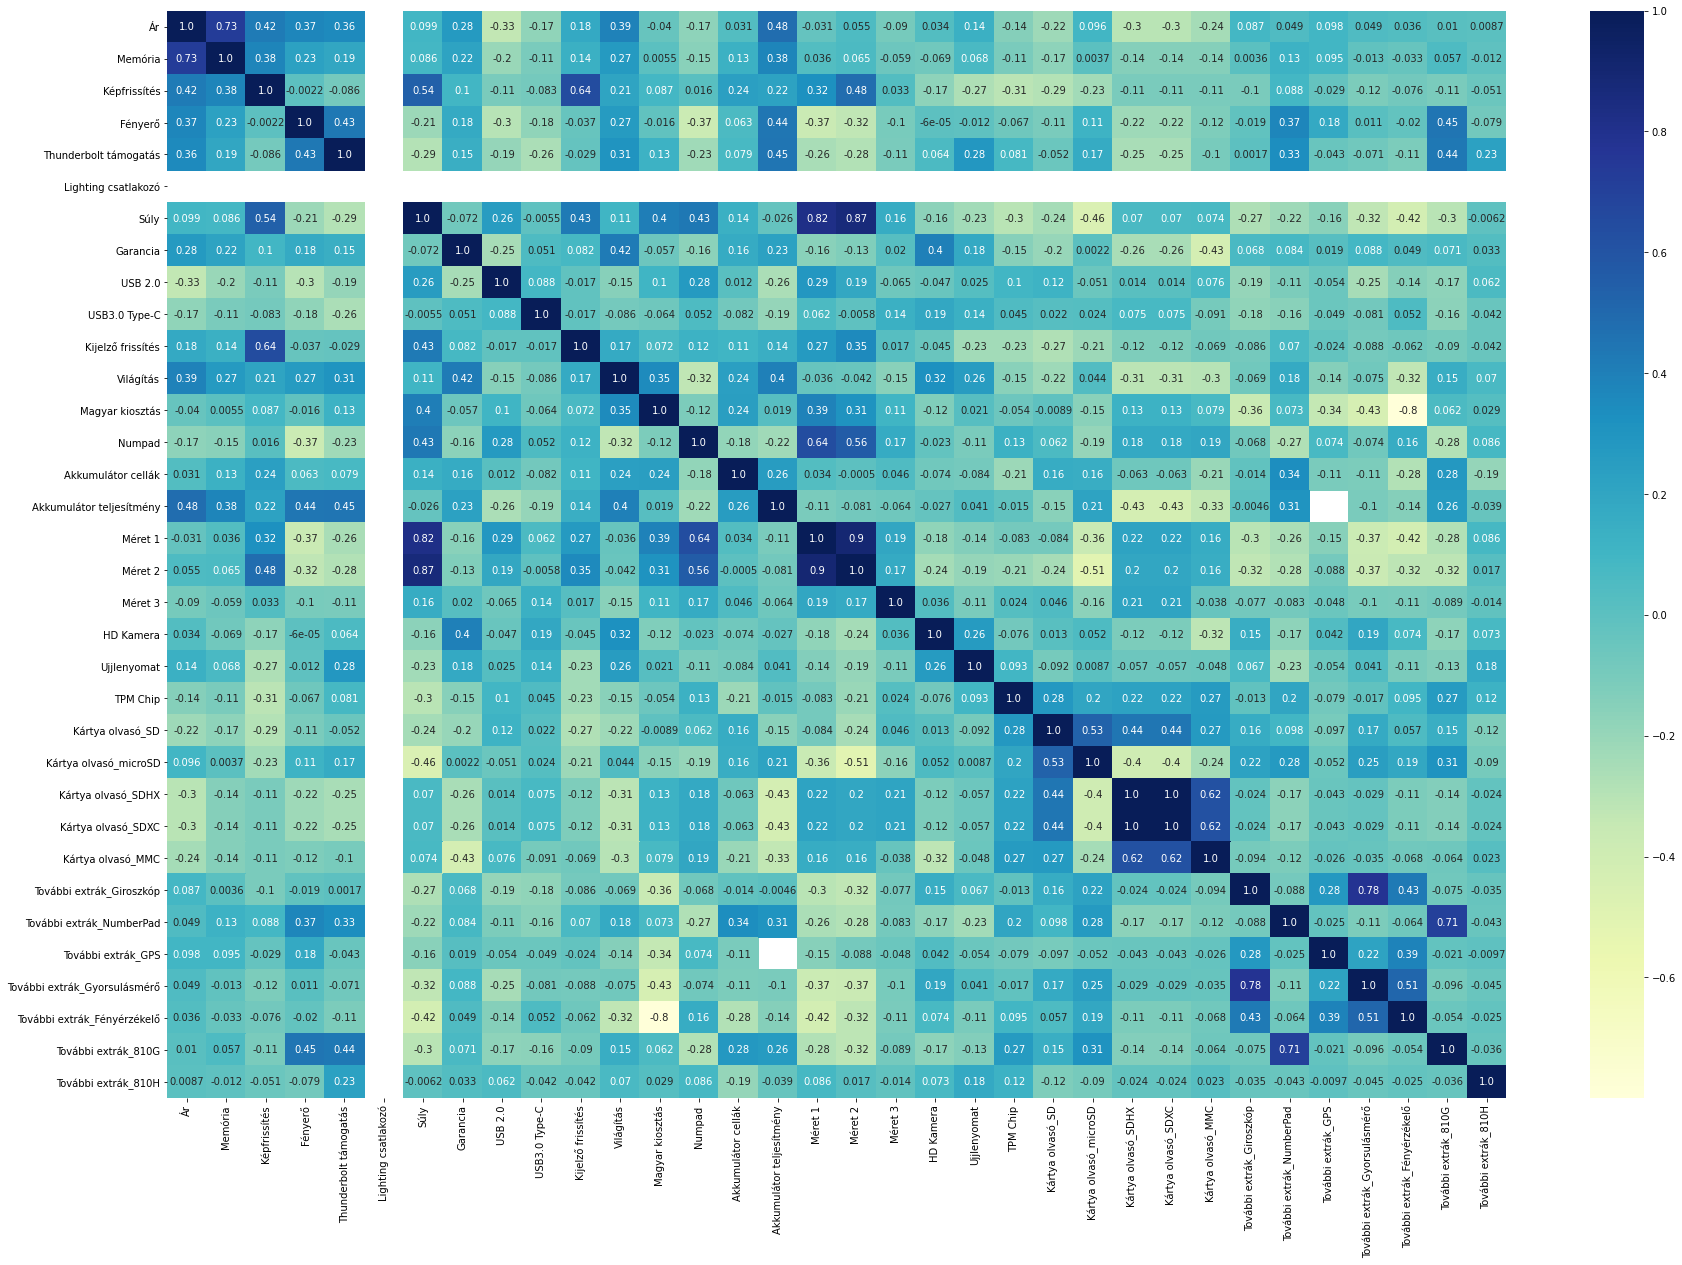

In [211]:
def plot_heatmap(df1):
    fig = plt.figure(figsize=(30,20)) 
    corr = df1.corr()
    sns.heatmap(corr, cmap='YlGnBu', annot=True, fmt='.2')
    plt.show()

plot_heatmap(df1)

On the above plot we can see the correlation between the features. We are most interested in what correlation the price has other features. We can see that  memory size and refresh rate are highly correlated with the price, however the extras have a small correlation (this does not surprise us though). 

One thing that's interesting is that battery performance is also an important metric when predicting the price. 

In [212]:
def get_columns_with_required_rows(df1, col_type, plots_per_row=4):
    filtered_data = df1.select_dtypes([col_type])
    required_rows = (len(filtered_data.columns.values)//plots_per_row) + 1

    return filtered_data.columns.values, required_rows

def numerical_plots(df1, plots_per_row):
    numerical_cols, required_rows = get_columns_with_required_rows(df1, 'number', plots_per_row)

    fig, axs = plt. subplots(required_rows, plots_per_row, figsize=(16,20))

    for var, ax in zip(numerical_cols, axs.flatten()):
        sns.histplot(df1[var], ax=ax)

    plt.tight_layout()
    plt.show()


def categorical_countplots(df1, plots_per_row):
    categorical_cols, required_rows = get_columns_with_required_rows(df1, 'category', plots_per_row)

    fig, axs = plt.subplots(required_rows, plots_per_row, figsize=(22,22))  # default 
    for var, ax in zip(categorical_cols, axs.flatten()):
        sns.countplot(df1[var], ax=ax)
        for label in ax.get_xticklabels():
            label.set_rotation(90)

    plt.tight_layout()
    plt.show()


def boxplot_with_target(df1, target, plots_per_row=4):
    categorical_cols, required_rows = get_columns_with_required_rows(df1, 'category', plots_per_row)

    fig, axs = plt.subplots(required_rows, plots_per_row, figsize=(22,22))
    for var, ax in zip(categorical_cols, axs.flatten()):
        sns.boxplot(x=var, y=target, data=df1, ax=ax)
        for label in ax.get_xticklabels():
            label.set_rotation(90)

    plt.tight_layout()
    plt.show()


def conditional_plot(df1, target_col, other_target, cond_col):
    cond_plot = sns.FacetGrid(data=df1, col=cond_col, col_wrap=4)
    cond_plot.map(sns.scatterplot, target, other_target)



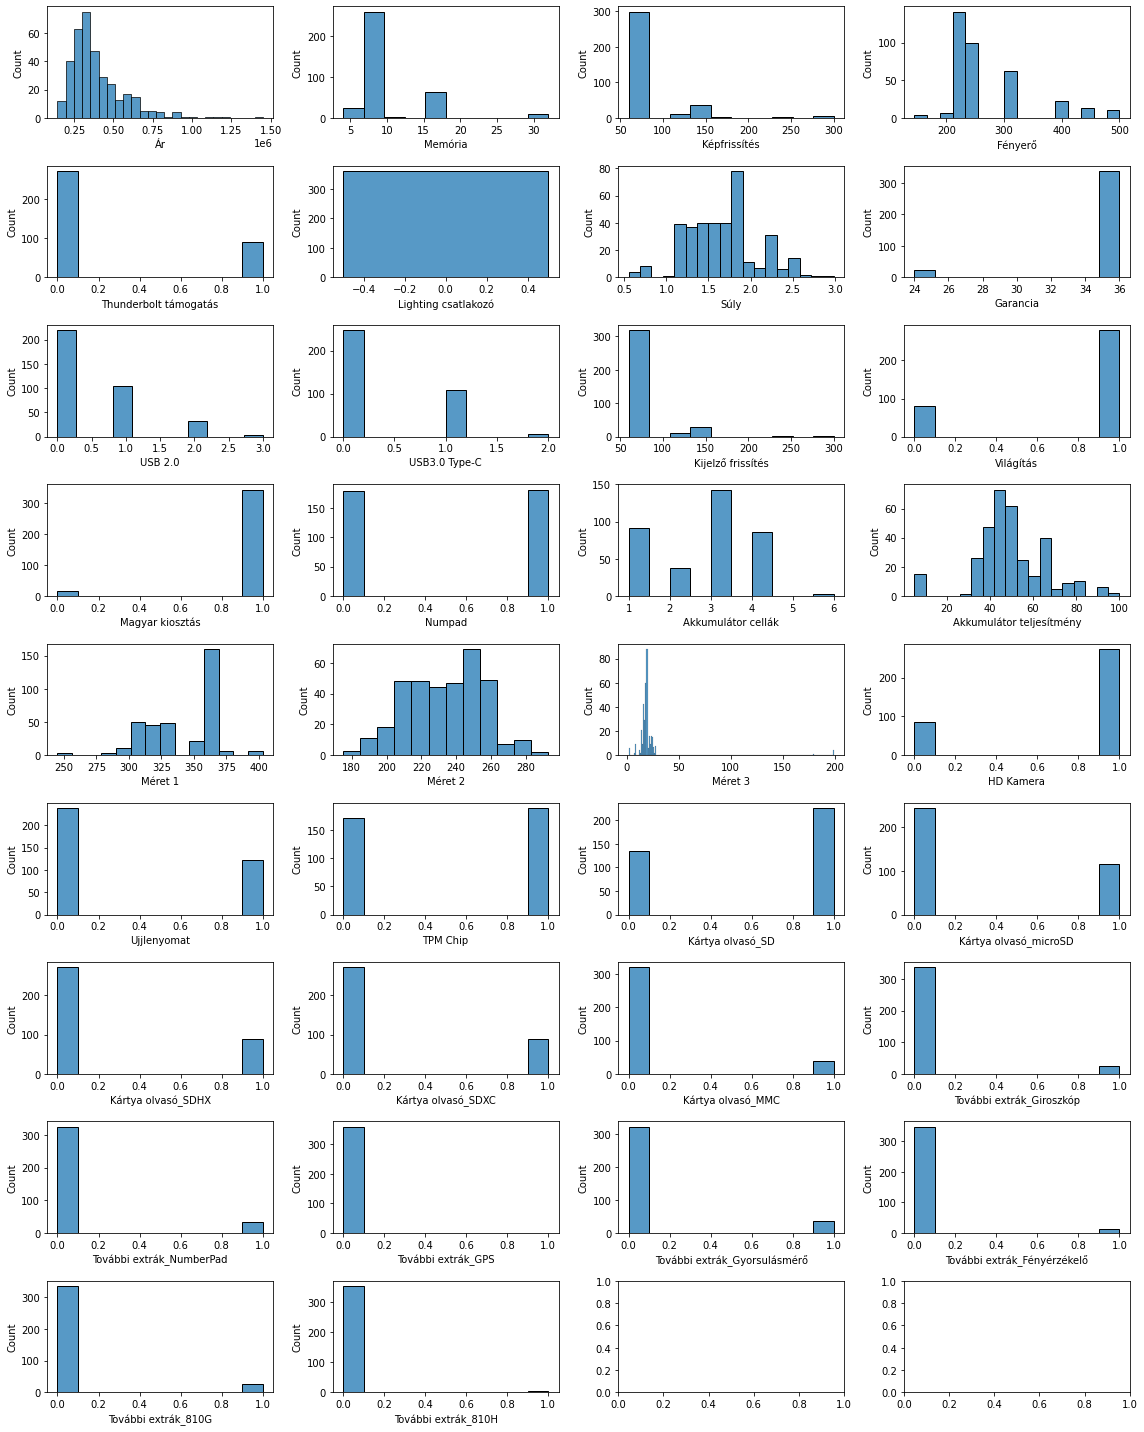

In [213]:
numerical_plots(df1, 4)

The most important fact from the plots above is that there are a couple of heavy outliers in 'Meret 3'. We must deal correct those!

Also the 'Lightning csatlakozó' feature has been showing weird things on every plot, I checked it out and all the values are missing. I will delete this feature.

The prices are right skewed, the other plots are easy to understand. 

In [214]:
def additional_cleaning(df1):
    del df1['Lighting csatlakozó']

    df1['Méret 3'] = df1['Méret 3'].replace(199.00, 19.00) # outlier due to typo
    delete_row = df1[df1['Ár'] == df1['Ár'].max()].index
    df1 = df1.drop(delete_row)

    return df1

df1 = additional_cleaning(df1)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


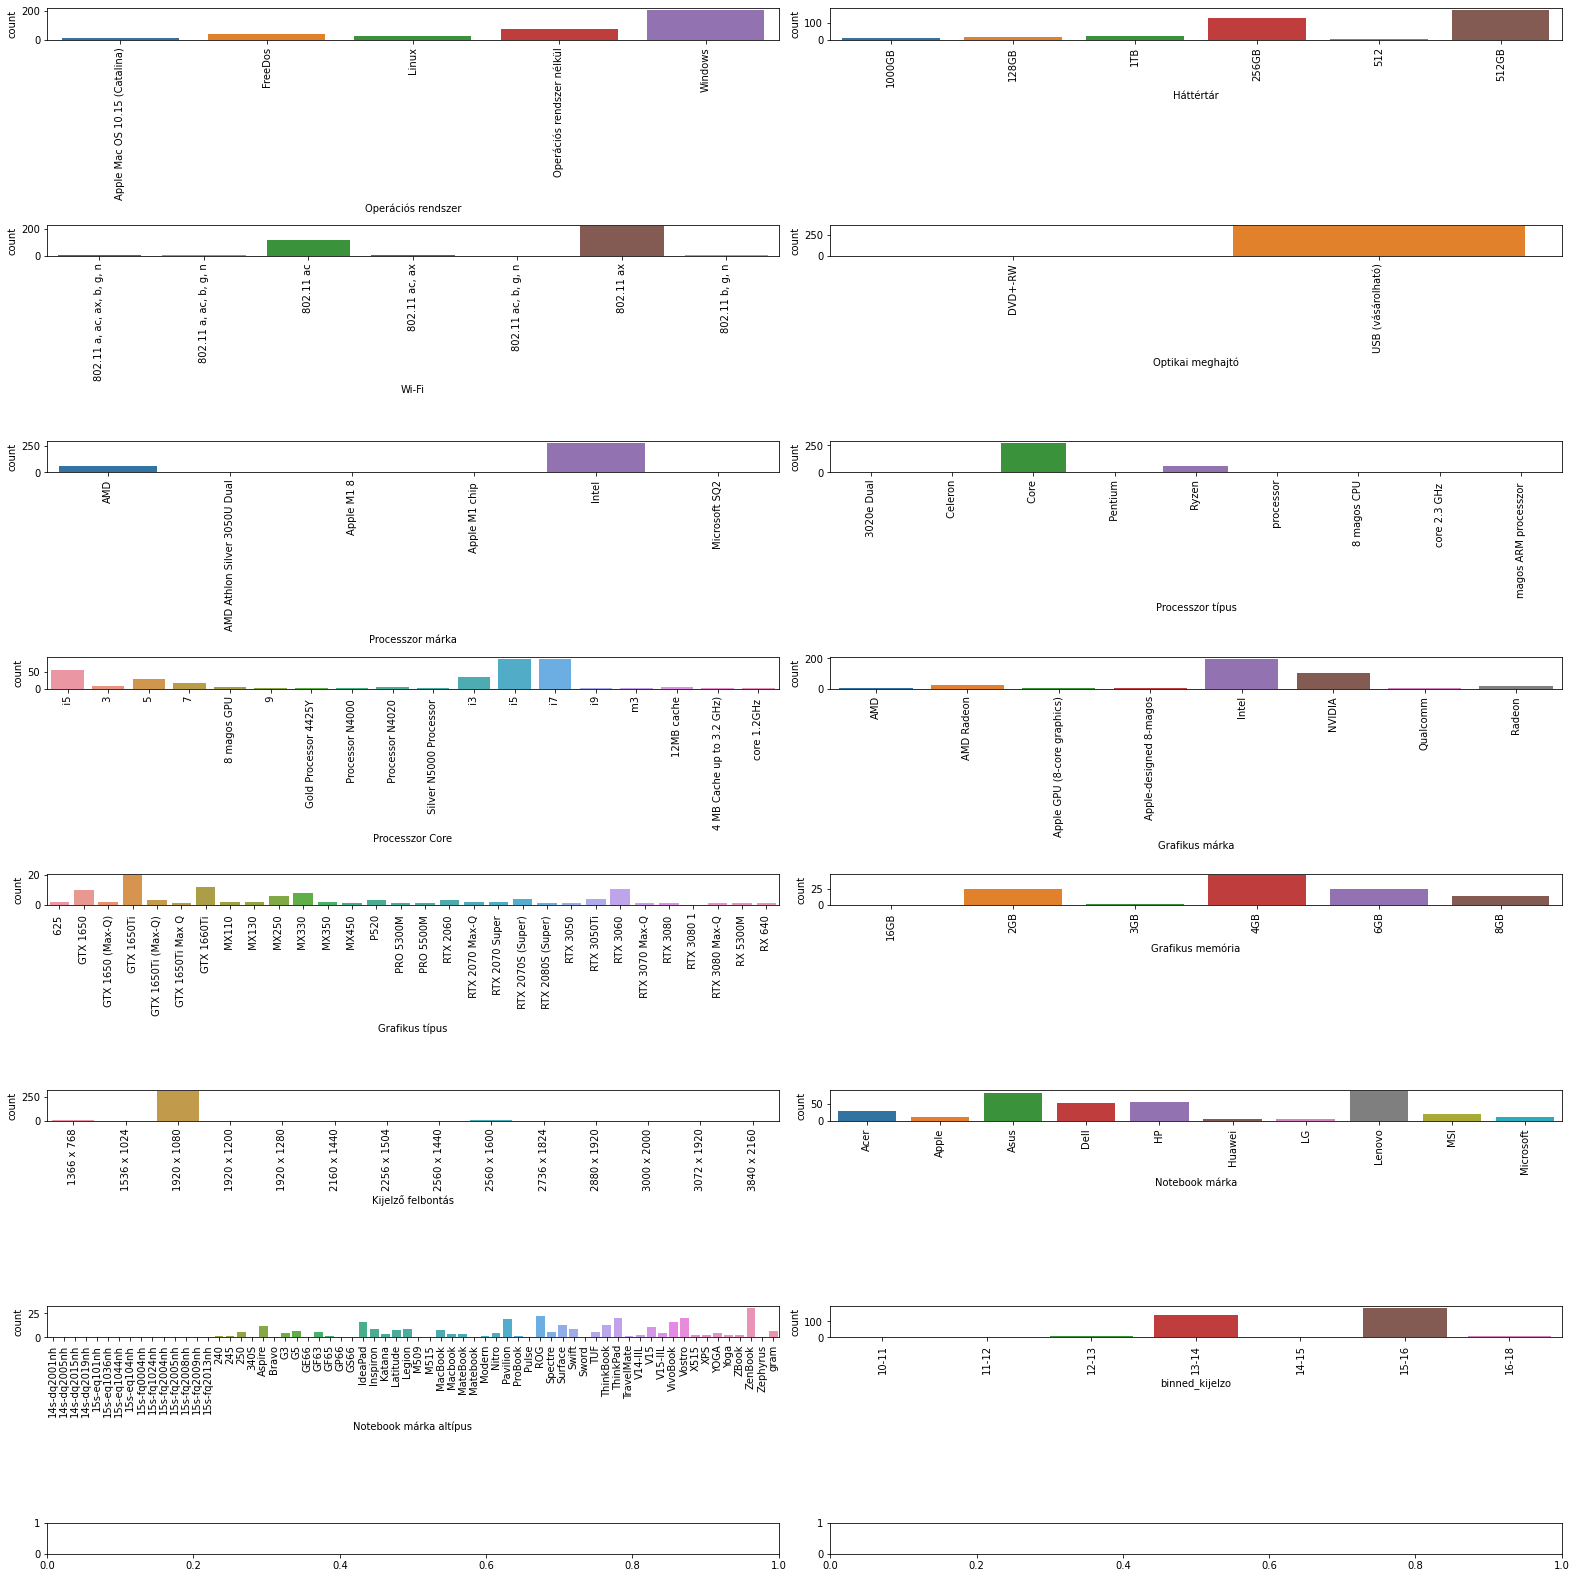

In [215]:
categorical_countplots(df1, 2)

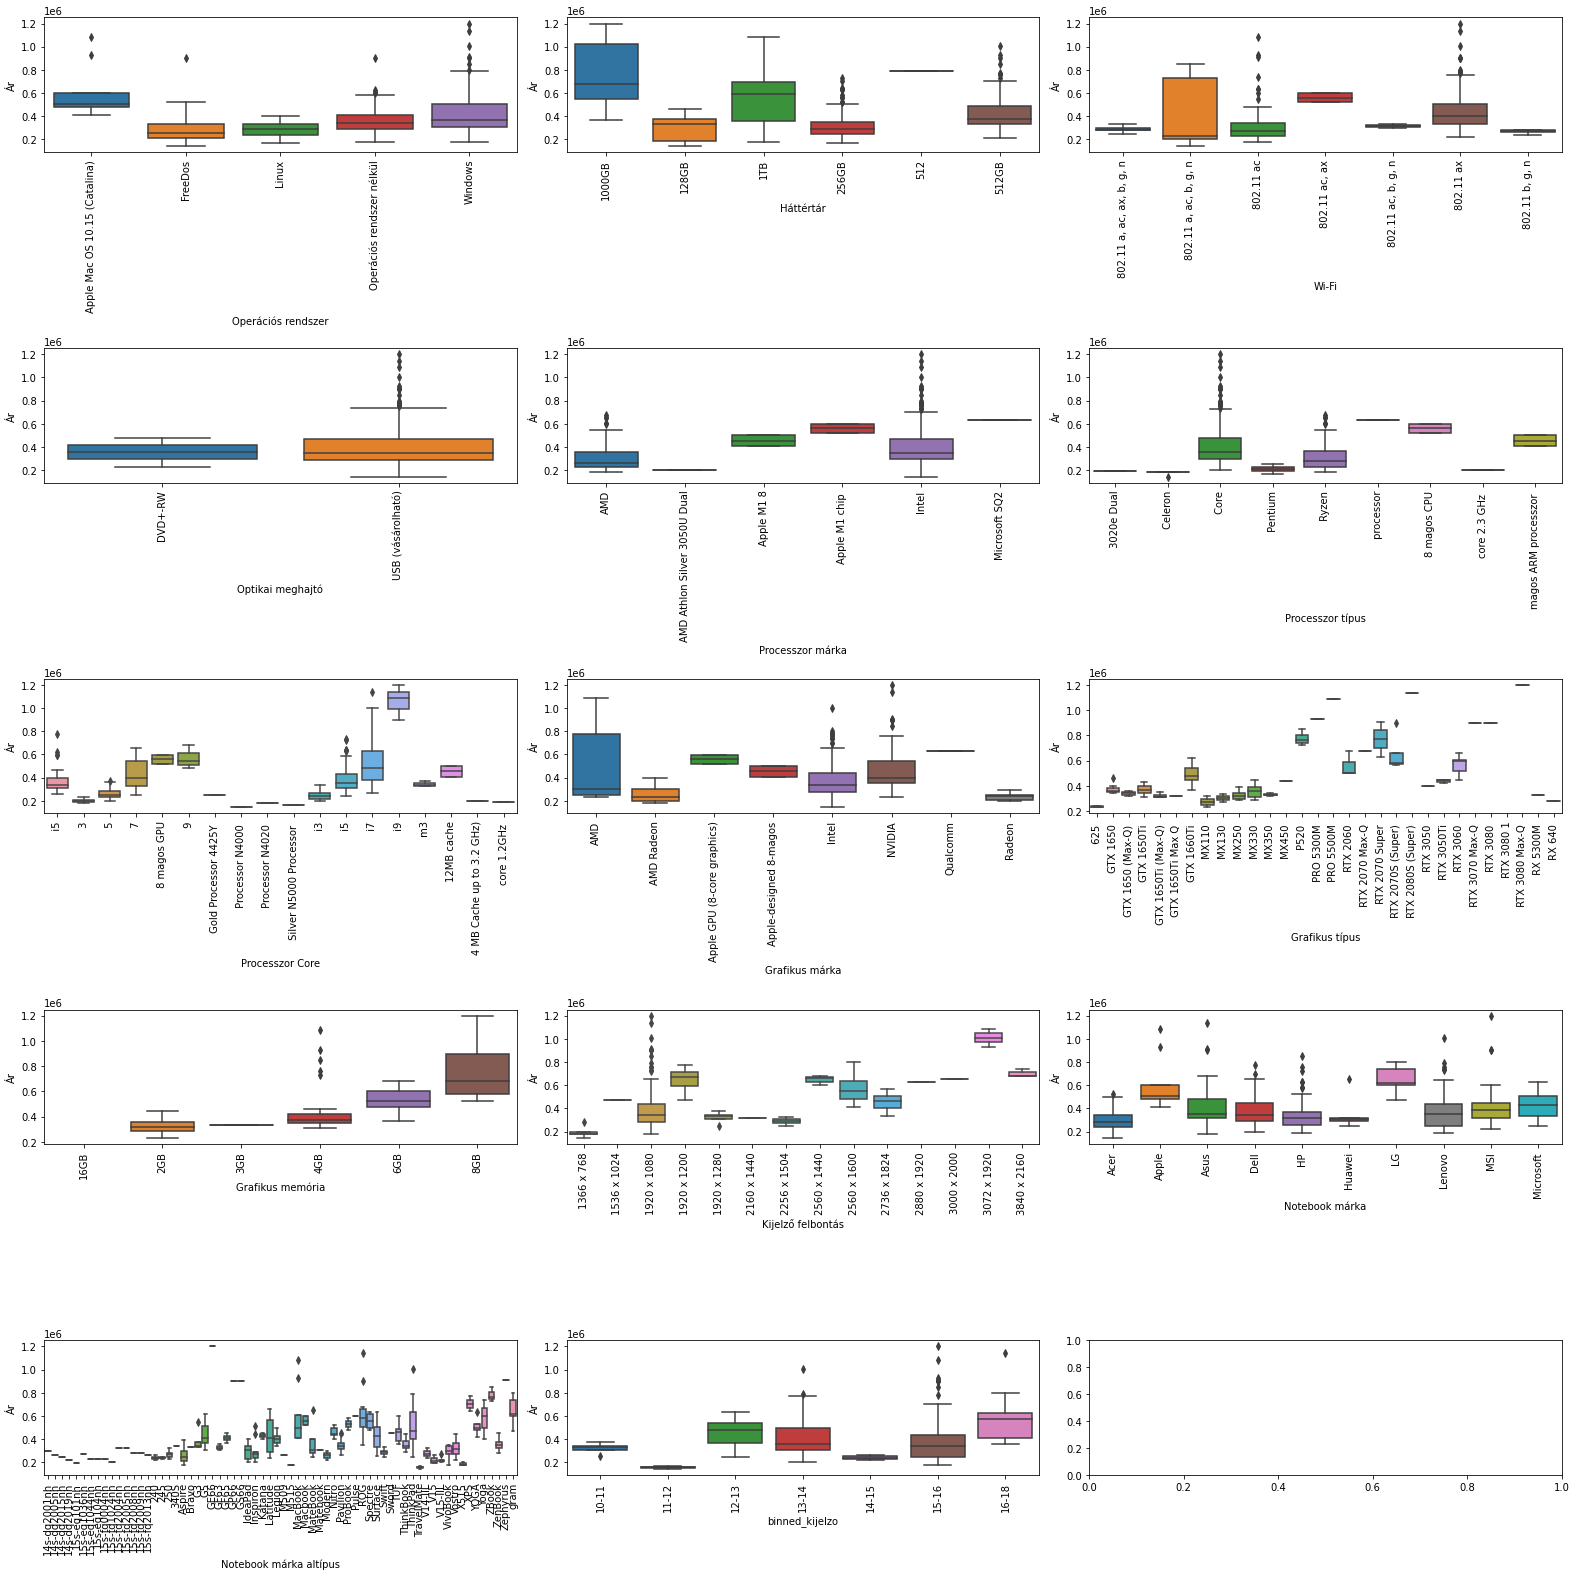

In [216]:
boxplot_with_target(df1, 'Ár', 3)

In [217]:
def one_hot_converter(df1):
    categorical_cols = df1.select_dtypes(['category'])
    
    for col in categorical_cols.columns.values:
        dummies = pd.get_dummies(df1[col])
        df1 = pd.concat([df1, dummies], axis=1)
        del df1[col]
    
    return df1 

one_hot_df = one_hot_converter(df1)
one_hot_df

,Ár,Memória,Képfrissítés,Fényerő,Thunderbolt támogatás,Súly,Garancia,USB 2.0,USB3.0 Type-C,Kijelző frissítés,Világítás,Magyar kiosztás,Numpad,Akkumulátor cellák,Akkumulátor teljesítmény,Méret 1,Méret 2,Méret 3,HD Kamera,Ujjlenyomat,TPM Chip,Kártya olvasó_SD,Kártya olvasó_microSD,Kártya olvasó_SDHX,Kártya olvasó_SDXC,Kártya olvasó_MMC,További extrák_Giroszkóp,További extrák_NumberPad,További extrák_GPS,További extrák_Gyorsulásmérő,További extrák_Fényérzékelő,További extrák_810G,További extrák_810H,Apple Mac OS 10.15 (Catalina),FreeDos,Linux,Operációs rendszer nélkül,Windows,1000GB,128GB,...,M509,M515,MacBook,Macbook,MateBook,Matebook,Modern,Nitro,Pavilion,ProBook,Pulse,ROG,Spectre,Surface,Swift,Sword,TUF,ThinkBook,ThinkPad,TravelMate,V14-IIL,V15,V15-IIL,VivoBook,Vostro,X515,XPS,YOGA,Yoga,ZBook,ZenBook,Zephyrus,gram,10-11,11-12,12-13,13-14,14-15,15-16,16-18
0,349900,8,144,250,0,2.30,36,0,0,144,1,1,0,3,48.0,360.00,275.00,25.80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,449900,16,144,220,0,1.86,36,0,0,60,1,1,0,3,51.0,359.00,254.00,21.70,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,309900,8,144,220,0,1.86,36,0,0,144,1,1,0,3,51.0,359.00,254.00,21.70,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,309900,8,60,250,0,2.55,36,2,0,60,1,1,1,4,68.0,364.46,254.00,28.18,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,179900,4,60,200,0,1.90,24,0,0,60,0,1,1,2,32.0,360.00,235.00,22.90,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,558900,8,60,250,1,1.37,36,0,0,60,1,1,0,4,63.0,321.40,212.00,19.30,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
356,339900,16,60,250,0,1.80,36,2,1,60,1,1,1,3,50.0,359.80,233.80,16.10,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
357,237900,8,60,220,0,1.91,36,1,1,60,0,1,1,3,40.0,361.40,247.85,17.97,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
358,374900,8,60,220,0,0.55,36,0,1,60,0,0,1,1,NaN,245.00,175.00,8.30,1,0,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [218]:
def fill_na_values(df1):
    df1['Grafikus memória'] = df1['Grafikus memória'].fillna('4GB')

    df1['Grafikus típus'] = df1['Grafikus típus'].cat.add_categories('No type')
    df1['Grafikus típus'] = df1['Grafikus típus'].fillna('No type')

    df1['Optikai meghajtó'] = df1['Optikai meghajtó'].cat.add_categories('No optical drive')
    df1['Optikai meghajtó'] = df1['Optikai meghajtó'].fillna('No optical drive')

    df1['Processzor Core'] = df1['Processzor Core'].cat.add_categories('No type given')
    df1['Processzor Core'] = df1['Processzor Core'].fillna('No type given')
    
    fill_mean_columns = ['Akkumulátor teljesítmény', 'Méret 1', 'Méret 2', 'Méret 3']
    for item in fill_mean_columns:
        df1[item] = df1[item].fillna(df1[item].mean())
    
    return df1

df1 = fill_na_values(df1)    

In [219]:
df1.isna().sum()

Ár                              0
Operációs rendszer              0
Memória                         0
Háttértár                       0
Képfrissítés                    0
Fényerő                         0
Wi-Fi                           0
Thunderbolt támogatás           0
Optikai meghajtó                0
Súly                            0
Garancia                        0
USB 2.0                         0
USB3.0 Type-C                   0
Processzor márka                0
Processzor típus                0
Processzor Core                 0
Grafikus márka                  0
Grafikus típus                  0
Grafikus memória                0
Kijelző felbontás               0
Kijelző frissítés               0
Világítás                       0
Magyar kiosztás                 0
Numpad                          0
Akkumulátor cellák              0
Akkumulátor teljesítmény        0
Méret 1                         0
Méret 2                         0
Méret 3                         0
HD Kamera     

In [220]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split

df1 = one_hot_converter(df1)

df1 = df1.reset_index()

X = df1.loc[:, df1.columns != 'Ár']
y = df1.loc[:, 'Ár']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1234)

model = RandomForestRegressor(n_estimators=10)
model.fit(X_train, y_train)

pred = model.predict(X_test)

print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, pred)))
mape = np.mean(np.abs((y_test - pred) / np.abs(y_test)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Accuracy:', round(100*(1 - mape), 2))

Mean Absolute Error (MAE): 52402.52100840336
Mean Squared Error (MSE): 6967638907.563025
Root Mean Squared Error (RMSE): 83472.3841013483
Mean Absolute Percentage Error (MAPE): 12.69
Accuracy: 87.31


In [221]:
final_df = pd.DataFrame(gt)
final_df['predicted'] = pred.astype(int)
final_df

,Ár,predicted
140,439900,489300
54,339900,307900
22,339900,368900
129,599900,712200
7,479900,354200
...,...,...
52,329900,326900
77,269900,262600
186,629900,549900
304,299900,328700


In [223]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

scores = []
kf = KFold(n_splits=3, random_state=1234, shuffle=True)

for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    lin_reg = linear_model.LinearRegression()
    lin_reg.fit(X_train, y_train)
    lin_reg_pred = lin_reg.predict(X_test)

    print(f"Mean squared error {mean_squared_error(y_test, lin_reg_pred)}")
    scores.append(mean_squared_error(y_test, lin_reg_pred))

print(f"Final mean squared error: {np.mean(scores)}")

#print(cross_val_score(lin_reg, X, y, cv=10))


Mean squared error 8.54935534834143e+33
Mean squared error 9.936658923130047e+32
Mean squared error 2.476796640243182e+32
Final mean squared error: 3.263566968226251e+33


Feature: 0, Score: 18259.23191
Feature: 1, Score: 193936.54264
Feature: 2, Score: 130391.00615
Feature: 3, Score: 78878.06031
Feature: 4, Score: 39304.73128
Feature: 5, Score: -302614.73409
Feature: 6, Score: -4938.69029
Feature: 7, Score: -6214.35923
Feature: 8, Score: -78355.20102
Feature: 9, Score: -24108.57431
Feature: 10, Score: 27318.40905
Feature: 11, Score: -57784.34215
Feature: 12, Score: -31966.04980
Feature: 13, Score: 53615.91185
Feature: 14, Score: -28074.10707
Feature: 15, Score: -186637.31840
Feature: 16, Score: 104387.43543
Feature: 17, Score: 211411.66103
Feature: 18, Score: -19870.04769
Feature: 19, Score: 39601.59385
Feature: 20, Score: -42231.82712
Feature: 21, Score: -13466.46613
Feature: 22, Score: 65123.67056
Feature: 23, Score: 27011582459603732.00000
Feature: 24, Score: -27011582459595776.00000
Feature: 25, Score: 36006.55062
Feature: 26, Score: 50223.14383
Feature: 27, Score: -54798.87558
Feature: 28, Score: -3047215675562110.00000
Feature: 29, Score: 23351.12

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


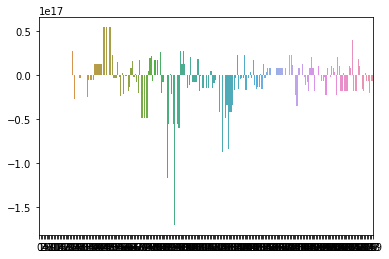

In [224]:
# get feature importance

importance = lin_reg.coef_

# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
sns.barplot([x for x in range(len(importance))], importance)
plt.show()

In [225]:
from sklearn.model_selection import cross_val_predict

cross_val_predict(lin_reg, X, y, cv=10)

array([ 3.52240000e+05,  4.69744000e+05,  3.18960000e+05,  3.26736000e+05,
        1.41776000e+05,  3.02832000e+05,  4.38688000e+05,  4.95680000e+05,
        2.41104000e+05,  1.62421413e+16,  1.64912000e+05,  3.24432000e+05,
        3.45712000e+05,  1.92880000e+05,  3.95600000e+05,  4.18352000e+05,
        3.67920000e+05,  4.16016000e+05,  3.20048000e+05, -2.34147828e+16,
       -1.19587045e+16,  2.19952000e+05,  3.69808000e+05, -3.48297404e+15,
        4.19152000e+05,  2.25520000e+05,  1.17978806e+16,  1.87037318e+16,
        2.19472000e+05,  4.14480000e+05,  1.45456000e+05,  6.47696000e+05,
        2.60176000e+05,  7.01552000e+05,  4.00720000e+05,  3.97936000e+05,
        5.28800000e+05,  5.85856000e+05,  2.59808000e+05,  3.45600000e+05,
        1.84800000e+05,  6.09152000e+05,  4.20288000e+05,  2.88256000e+05,
        1.99742435e+15,  6.82208000e+05,  7.83436376e+14,  3.93504000e+05,
        1.58997860e+15,  3.06752000e+05,  2.28032000e+05,  7.27584000e+05,
        3.27008000e+05,  